# HW3: Classification

Please complete this notebook by filling in the cells provided. Before you begin, execute the following cell to load required modules. Each time you start your server, you will need to execute this cell again to load the modules.


We will work with two datasets
1. Sensors - This dataset classifies if a room is occupied or not based on sensor readings https://archive.ics.uci.edu/ml/datasets/Occupancy+Detection+
2. FMNIST - This dataset classifies 10 types of images of clothing https://github.com/zalandoresearch/fashion-mnist

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import calibration_curve
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
from sklearn.preprocessing import OneHotEncoder
def brier_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return np.mean(np.sum((probs - target_enc)**2, axis=1))

def log_score(targets, probs):
  enc = OneHotEncoder()
  target_enc = enc.fit_transform(np.array(targets).reshape(-1, 1)).toarray()
  return -np.mean(np.sum(target_enc * np.log(probs + 1e-32), axis=1))

# Question 1 -- Room Occupancy

Suppose you're an engineer working on smart home devices, such as a thermostat that only turns on the heat when a room is occupied.

You need to know when a room is occupied so you devise the following system:
1. Each customer will purchase (from you) four sensors which they place around the room.
2. Each sensor is high quality and measures the ambient temperature, lighting, and sound level of the room with high precision
3. Based on these sensors readings you want to design a model that will predict if the room is occupied or not.

You test out these sensors and gather the following data
1. temp, light, and sound measurements from each sensor
2. whether the room is occupied or not




In [ ]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00640/Occupancy_Estimation.csv'
occ = pd.read_csv(url).drop(['Date', 'Time', 'S5_CO2', 'S5_CO2_Slope', 'S6_PIR', 'S7_PIR'], axis = 1)
occ['occupied'] = 1.0*(occ['Room_Occupancy_Count'] != 0)
occ  = occ.drop(['Room_Occupancy_Count'], axis = 1).astype(int)
occ.head()

,S1_Temp,S2_Temp,S3_Temp,S4_Temp,S1_Light,S2_Light,S3_Light,S4_Light,S1_Sound,S2_Sound,S3_Sound,S4_Sound,occupied
0,24,24,24,25,121,34,53,40,0,0,0,0,1
1,24,24,24,25,121,33,53,40,0,0,0,0,1
2,25,24,24,25,121,34,53,40,0,0,0,0,1
3,25,24,24,25,121,34,53,40,0,0,0,0,1
4,25,24,24,25,121,34,54,40,0,0,0,0,1


# part 1.a

First split the data into a feature array `x` and label array `y`
- `x` should contain all sensor readings
- `y` should be only the occupied column

Second split the data into training and testing data with a test size of 33% using random state 42 to get the usual `x_train, x_test, y_train, y_test` datasets

In [ ]:
# make x and y
x = occ.drop(['occupied'], axis=1)
y = occ['occupied']
# split intro train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# part 1.b

Train Logistic regression, LDA, QDA, and Naive Bayes classifiers

1. Compute the Brier score and Log score for each method on the test dataset
2. Which model has better Brier score? Which has better log score? Logistic

In [ ]:
# fit models
logistic_regression = LogisticRegression()
lda = LDA()
qda = QDA()
naive_bayes = GaussianNB()

logistic_regression.fit(x_train, y_train)
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)
naive_bayes.fit(x_train, y_train)

GaussianNB()

In [ ]:
# predict probabilities
logistic_regression_pred = logistic_regression.predict_proba(x_test)
lda_pred = lda.predict_proba(x_test)
qda_pred = qda.predict_proba(x_test)
naive_bayes_pred = naive_bayes.predict_proba(x_test)
# predict labels
logistic_test = logistic_regression.predict(x_test)
lda_test = lda.predict(x_test)
qda_test = qda.predict(x_test)
naive_test = naive_bayes.predict(x_test)

In [ ]:
print('Brier score')
print('')

print('Logistic Regression:', np.round(brier_score(y_test, logistic_regression_pred), 3))
print('LDA:', np.round(brier_score(y_test, lda_pred), 3))
print('QDA:', np.round(brier_score(y_test, qda_pred), 3))
print('Naive Bayes:', np.round(brier_score(y_test, naive_bayes_pred), 3))

Brier score

Logistic Regression: 0.012
LDA: 0.035
QDA: 0.034
Naive Bayes: 0.073


In [ ]:
print('Log score')
print('')

print('Logistic Regression:', np.round(log_score(y_test, logistic_regression_pred), 3))
print('LDA:', np.round(log_score(y_test, lda_pred), 3))
print('QDA:', np.round(log_score(y_test, qda_pred), 3))
print('Naive Bayes:', np.round(log_score(y_test, naive_bayes_pred), 3))

Log score

Logistic Regression: 0.024
LDA: 0.34
QDA: 0.709
Naive Bayes: 0.714


Which model is better?
The model with the best Brier Score is the logistic Regression Model and the model with the best log score is also the logistic regression model so I would say that it is safe to assume that the best model is the logistic regression model.



# part 1.c

Compute the precision, recall, and F1 score of each method for each target category (1 and 0).

1. Summarize these metrics in tables (one for each model)
2. Which model has the highest average F1 score? Logistic

In [ ]:
logit_class_report = metrics.classification_report(y_test, logistic_test)
print("Logistic Report")
print(logit_class_report)

lda_class_report = metrics.classification_report(y_test, lda_test)
print("LDA Report")
print(lda_class_report)

qda_class_report = metrics.classification_report(y_test, qda_test)
print("QDA Report")
print(qda_class_report)

naive_class_report = metrics.classification_report(y_test, naive_test)
print("Naive Report")
print(naive_class_report)

Logistic Report
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      2700
           1       0.98      0.99      0.98       643

    accuracy                           0.99      3343
   macro avg       0.99      0.99      0.99      3343
weighted avg       0.99      0.99      0.99      3343

LDA Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2700
           1       1.00      0.91      0.95       643

    accuracy                           0.98      3343
   macro avg       0.99      0.96      0.97      3343
weighted avg       0.98      0.98      0.98      3343

QDA Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2700
           1       0.99      0.92      0.95       643

    accuracy                           0.98      3343
   macro avg       0.99      0.96      0.97      3343
weighted avg       0.98      0.98   

Which model is better?

The model with the highest average F1 score is the Logistic regression model as it also has the best average precsion and recall, therefore the Logistic Regression model is better.


# part 1.d

Now lets look at the tradeoff between sensitivity and specificty. Create a ROC curve for each model and display them in a single plot.

1. Which model has a higher AUC? Logistics Regression has a higher area under the curve but only by .0003 more than LDA does.
2. Are these models close to perfect? I think the logistic regression model is close to perefect because it has a low brier score and log score and a corresponding high AUC. The other three models have good low brier scores and high area's under the cureve but the all have log scores that are higher than what is ideal. LDA has a log score of .34 with a good brier andf AUC so LDA provides the next best model.

In [ ]:
# compute roc curves for each method. Store fpr, tpr, and thresholds
fpr_lda, tpr_lda, thresholds = roc_curve(y_test, lda_pred[:,1])
fpr_qda, tpr_qda, thresholds = roc_curve(y_test, qda_pred[:,1])
fpr_logistic, tpr_logistic, thresholds = roc_curve(y_test, logistic_regression_pred[:,1])
fpr_naive, tpr_naive, thresholds = roc_curve(y_test, naive_bayes_pred[:,1])

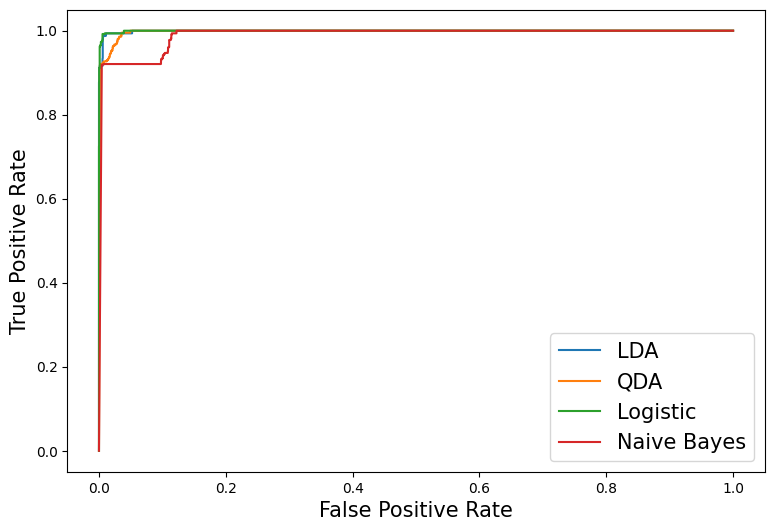

In [ ]:
# plt each roc curve on the same figure
plt.figure(figsize = (9, 6))
plt.plot(fpr_lda, tpr_lda, label = 'LDA')
plt.plot(fpr_qda, tpr_qda, label = 'QDA')
plt.plot(fpr_logistic, tpr_logistic, label = 'Logistic')
plt.plot(fpr_naive, tpr_naive, label = 'Naive Bayes')
plt.xlabel('False Positive Rate', fontsize = 15)
plt.ylabel('True Positive Rate', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

In [ ]:
print('Area under the curve (AUC)')
print('')
print('LDA:', np.round(roc_auc_score(y_test, lda_pred[:,1]), 4))
print('QDA:', np.round(roc_auc_score(y_test, qda_pred[:,1]), 4))
print('Logistic Regression:', np.round(roc_auc_score(y_test, logistic_regression_pred[:,1]), 4))
print('Naive Bayes:', np.round(roc_auc_score(y_test, naive_bayes_pred[:,1]), 4))

Area under the curve (AUC)

LDA: 0.9992
QDA: 0.9974
Logistic Regression: 0.9995
Naive Bayes: 0.9894


# part 1.e

Create a calibration curve for each model with at least 20 bins using quantile binning.

1. Plot and label the calibration curves. Include a line to represent perfect calibration.
2. Which model is the most calibrated? The Most calibrated model is the logistic regression model as it is closest to the line of perfect calibration.


In [ ]:
# compute calibration curves for each model
probabilites = {
    'Logistic Regression': logistic_regression_pred[:, 1],
    'LDA': lda_pred[:, 1],
    'QDA': qda_pred[:, 1],
    'Naive Bayes': naive_bayes_pred[:, 1]
}

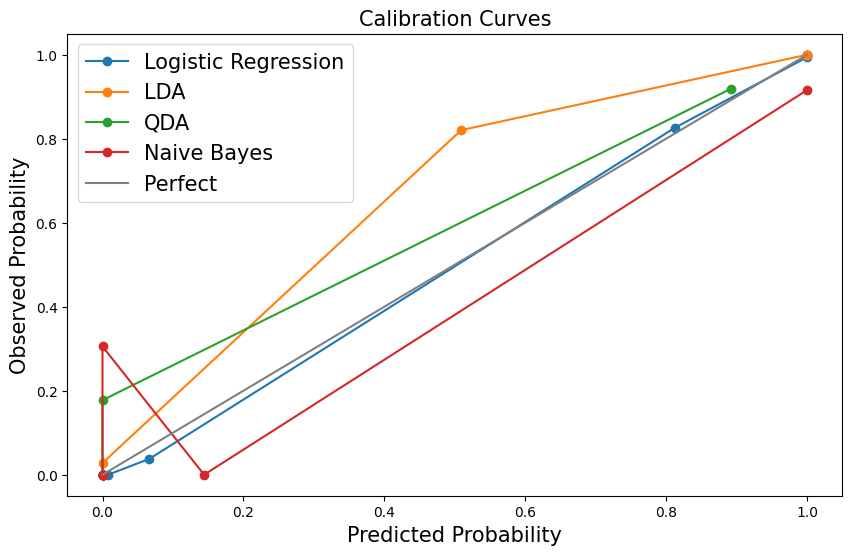

In [ ]:
# plot each calibration curve on the same figure
plt.figure(figsize = (10, 6))

for name, prob in probabilites.items():
    true, pred = calibration_curve(y_test, prob, n_bins=20, strategy='quantile')
    plt.plot(pred, true, marker='o', label=name)
plt.plot([1, 0], [1, 0], color='grey', label='Perfect')
plt.title('Calibration Curves', fontsize=15)
plt.xlabel('Predicted Probability', fontsize = 15)
plt.ylabel('Observed Probability', fontsize = 15)
plt.legend(fontsize = 15)
plt.show()

# part 1.f

You find that the system works!


The only thing is these sensors are kind of expensive. Perhaps we can get similar performance with less sensors? That way the whole system will be cheaper and perhaps more people will buy it.

Test each sensor individually (using all three measurements) to see if you can build a classifier that is nearly as good as a classifier that uses all sensors.


1. Refit each model using only the data from a single sensor. For example if you want to use only sensor 1's data then only inlcude `['S1_Temp', 'S1_Light', 'S1_Sound']` as features. Save the Brier and log score for each model and each sensor. Print as a table so that I can tell what the brier and log score are for each model using each sensor.
1. Which sensor is best? Does it depend on the chosen model (Naive Bayes, LDA, QDA, vs Logistic Regression)? The best sensor appears to be the S1 sensors as they have most of the lowest brier and log scores for each model. It does somewhat depend on the model we use for the sensors as you can see by the log score being higher for S1 than for S2 and S3 whenever we use the Naive Bayes Modelm however the logistic regression model is clearly the best model again and S1 has the lowest scores for logistic regression.

2. How much does using the best sensor increase the Brier / log score and decrease the F1 score compared to using all sensors simultaneously?

Using the best sensor S1 increases the Brier and log score for the best model logistic regression by about .02 and .06 respectively and the brier scores for the other model versions were roughly the same while a few of the log scores actually decreased. The F1 score decreases slightly by about .01 to .02 for each model when we use S1 compared to all sensors and specifically the average for the Logistic Regression model descreases by .01.

In [ ]:
# example using only sensor 1. You need to repeat for each sensor.
x = occ.loc[:, ['S1_Temp', 'S1_Light', 'S1_Sound']]
y = occ.loc[:,['occupied']]


x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# fit models
logistic_regression = LogisticRegression()
lda = LDA()
qda = QDA()
naive_bayes = GaussianNB()

logistic_regression.fit(x_train, y_train)
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)
naive_bayes.fit(x_train, y_train)

logistic_test = logistic_regression.predict(x_test)
lda_test = lda.predict(x_test)
qda_test = qda.predict(x_test)
naive_test = naive_bayes.predict(x_test)

In [ ]:
# fit each model and save the brier and log scores
scores = []

sensors = {
    'S1': occ.loc[:, ['S1_Temp', 'S1_Light', 'S1_Sound']],
    'S2': occ.loc[:, ['S2_Temp', 'S2_Light', 'S2_Sound']],
    'S3': occ.loc[:, ['S3_Temp', 'S3_Light', 'S3_Sound']],
    'S4': occ.loc[:, ['S4_Temp', 'S4_Light', 'S4_Sound']]
}

for sensor, x in sensors.items():
    y = occ.loc[:,['occupied']]

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

    logistic_regression = LogisticRegression()
    lda = LDA()
    qda = QDA()
    naive_bayes = GaussianNB()

    logistic_regression.fit(x_train, y_train)
    lda.fit(x_train, y_train)
    qda.fit(x_train, y_train)
    naive_bayes.fit(x_train, y_train)

    logistic_regression_pred = logistic_regression.predict_proba(x_test)
    lda_pred = lda.predict_proba(x_test)
    qda_pred = qda.predict_proba(x_test)
    naive_bayes_pred = naive_bayes.predict_proba(x_test)

    brier_scores = [brier_score(y_test, probas) for probas in [logistic_regression_pred, lda_pred, qda_pred, naive_bayes_pred]]
    log_scores = [log_score(y_test, probas) for probas in [logistic_regression_pred, lda_pred, qda_pred, naive_bayes_pred]]

    scores.extend([(sensor, 'Logistic Regression', brier_scores[0], log_scores[0]),
                    (sensor, 'LDA', brier_scores[1], log_scores[1]),
                    (sensor, 'QDA', brier_scores[2], log_scores[2]),
                    (sensor, 'Naive Bayes', brier_scores[3], log_scores[3])])

In [ ]:
# Print out brier and log scores as a table for each model.
# Consider stuffing your results into a pandas dataframe and print that.
# make sure everything is labeled
# Print the table of results
scores_table = pd.DataFrame(scores, columns=['Sensor', 'Model', 'Brier Score', 'Log Score'])
print(scores_table)

   Sensor                Model  Brier Score  Log Score
0      S1  Logistic Regression     0.033703   0.080004
1      S1                  LDA     0.034698   0.346398
2      S1                  QDA     0.077676   0.372975
3      S1          Naive Bayes     0.077708   0.414331
4      S2  Logistic Regression     0.077324   0.125676
5      S2                  LDA     0.184969   0.362528
6      S2                  QDA     0.085105   0.283945
7      S2          Naive Bayes     0.097229   0.337529
8      S3  Logistic Regression     0.150879   0.229199
9      S3                  LDA     0.172653   0.301865
10     S3                  QDA     0.188662   0.462406
11     S3          Naive Bayes     0.189242   0.482738
12     S4  Logistic Regression     0.229926   0.349108
13     S4                  LDA     0.242542   0.368570
14     S4                  QDA     0.290220   0.501841
15     S4          Naive Bayes     0.304216   0.536367


In [ ]:
# F1 Score for Sensor 1
logit_class_report = metrics.classification_report(y_test, logistic_test)
print("Logistic Report S1")
print(logit_class_report)

lda_class_report = metrics.classification_report(y_test, lda_test)
print("LDA Report S1")
print(lda_class_report)

qda_class_report = metrics.classification_report(y_test, qda_test)
print("QDA Report S1")
print(qda_class_report)

naive_class_report = metrics.classification_report(y_test, naive_test)
print("Naive Report S1")
print(naive_class_report)

Logistic Report S1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2700
           1       1.00      0.91      0.95       643

    accuracy                           0.98      3343
   macro avg       0.99      0.96      0.97      3343
weighted avg       0.98      0.98      0.98      3343

LDA Report S1
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2700
           1       1.00      0.91      0.95       643

    accuracy                           0.98      3343
   macro avg       0.99      0.96      0.97      3343
weighted avg       0.98      0.98      0.98      3343

QDA Report S1
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2700
           1       0.89      0.91      0.90       643

    accuracy                           0.96      3343
   macro avg       0.93      0.94      0.94      3343
weighted avg       0.96    

# part 1.g

Regardless of your findings above, suppose sensor 1 is the only one available due to supply chain issues.

You wonder if all three measurements are even necessary. Using sensor 1, see if any of the measurements (Temp, Light, or Sound) can be dropped from the model without significantly deteriorating performance. Significant deterioration is defined as an increase in test Brier of 5%.


1. Can you achieve a Brier score (on test), using only 1 or 2 variables,  that is within 5% of the Brier score of the model using all 3? Yes I was able to achive these for a model that included Temp and Light only and for another model that included Light and sound only. This made me believe that maybe a model with just light work without significiant deteriioration and when I ran that model I found that using just light as the predictor variable was just as effective and did not have significant deterioation.
2. Which variables are they? The Model with just S1_Temp and S1_Light, the model with S1_Sound and S1_Light, and the model with just S1_Light.

In [ ]:
# find the smallest set of features that can be retained. Example using only temperature and sound
x = occ.loc[:, ['S1_Temp', 'S1_Sound']]
y = occ.loc[:,['occupied']]
x2 = occ.loc[:, ['S1_Temp', 'S1_Light']]
x3 = occ.loc[:, ['S1_Light', 'S1_Sound']]
x4 = occ.loc[:, ['S1_Light']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y, test_size=0.33, random_state=42)
x_train3, x_test3, y_train3, y_test3 = train_test_split(x3, y, test_size=0.33, random_state=42)
x_train4, x_test4, y_train4, y_test4 = train_test_split(x4, y, test_size=0.33, random_state=42)

In [ ]:
# Fit the models and compute the Brier scores
# fit models
logistic_regression = LogisticRegression()
lda = LDA()
qda = QDA()
naive_bayes = GaussianNB()

# for no light
logistic_regression.fit(x_train, y_train)
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)
naive_bayes.fit(x_train, y_train)

# predict probabilities
logistic_regression_pred = logistic_regression.predict_proba(x_test)
lda_pred = lda.predict_proba(x_test)
qda_pred = qda.predict_proba(x_test)
naive_bayes_pred = naive_bayes.predict_proba(x_test)
# predict labels
logistic_test = logistic_regression.predict(x_test)
lda_test = lda.predict(x_test)
qda_test = qda.predict(x_test)
naive_test = naive_bayes.predict(x_test)

print('Brier score No Light')
print('')

print('Logistic Regression:', np.round(brier_score(y_test, logistic_regression_pred), 3))
print('LDA:', np.round(brier_score(y_test, lda_pred), 3))
print('QDA:', np.round(brier_score(y_test, qda_pred), 3))
print('Naive Bayes:', np.round(brier_score(y_test, naive_bayes_pred), 3))

Brier score No Light

Logistic Regression: 0.172
LDA: 0.198
QDA: 0.19
Naive Bayes: 0.19


In [ ]:
# for no sound
logistic_regression.fit(x_train2, y_train2)
lda.fit(x_train2, y_train2)
qda.fit(x_train2, y_train2)
naive_bayes.fit(x_train2, y_train2)

# predict probabilities
logistic_regression_pred2 = logistic_regression.predict_proba(x_test2)
lda_pred2 = lda.predict_proba(x_test2)
qda_pred2 = qda.predict_proba(x_test2)
naive_bayes_pred2 = naive_bayes.predict_proba(x_test2)
# predict labels
logistic_test2 = logistic_regression.predict(x_test2)
lda_test2 = lda.predict(x_test2)
qda_test2 = qda.predict(x_test2)
naive_test2 = naive_bayes.predict(x_test2)

print('Brier score No Sound')
print('')

print('Logistic Regression:', np.round(brier_score(y_test2, logistic_regression_pred2), 3))
print('LDA:', np.round(brier_score(y_test2, lda_pred2), 3))
print('QDA:', np.round(brier_score(y_test2, qda_pred2), 3))
print('Naive Bayes:', np.round(brier_score(y_test2, naive_bayes_pred2), 3))

Brier score No Sound

Logistic Regression: 0.034
LDA: 0.035
QDA: 0.079
Naive Bayes: 0.078


In [ ]:
# for no temp
logistic_regression.fit(x_train3, y_train3)
lda.fit(x_train3, y_train3)
qda.fit(x_train3, y_train3)
naive_bayes.fit(x_train3, y_train3)

# predict probabilities
logistic_regression_pred3 = logistic_regression.predict_proba(x_test3)
lda_pred3 = lda.predict_proba(x_test3)
qda_pred3 = qda.predict_proba(x_test3)
naive_bayes_pred3 = naive_bayes.predict_proba(x_test3)
# predict labels
logistic_test3 = logistic_regression.predict(x_test3)
lda_test3 = lda.predict(x_test3)
qda_test3 = qda.predict(x_test3)
naive_test3 = naive_bayes.predict(x_test3)

print('Brier score No Temp')
print('')

print('Logistic Regression:', np.round(brier_score(y_test3, logistic_regression_pred3), 3))
print('LDA:', np.round(brier_score(y_test3, lda_pred3), 3))
print('QDA:', np.round(brier_score(y_test3, qda_pred3), 3))
print('Naive Bayes:', np.round(brier_score(y_test3, naive_bayes_pred3), 3))

Brier score No Temp

Logistic Regression: 0.034
LDA: 0.035
QDA: 0.035
Naive Bayes: 0.035


In [ ]:
# for light only
logistic_regression.fit(x_train4, y_train4)
lda.fit(x_train4, y_train4)
qda.fit(x_train4, y_train4)
naive_bayes.fit(x_train4, y_train4)

# predict probabilities
logistic_regression_pred4 = logistic_regression.predict_proba(x_test4)
lda_pred4 = lda.predict_proba(x_test4)
qda_pred4 = qda.predict_proba(x_test4)
naive_bayes_pred4 = naive_bayes.predict_proba(x_test4)
# predict labels
logistic_test4 = logistic_regression.predict(x_test4)
lda_test4 = lda.predict(x_test4)
qda_test4 = qda.predict(x_test4)
naive_test4 = naive_bayes.predict(x_test4)

print('Brier score Light Only')
print('')

print('Logistic Regression:', np.round(brier_score(y_test4, logistic_regression_pred4), 3))
print('LDA:', np.round(brier_score(y_test4, lda_pred4), 3))
print('QDA:', np.round(brier_score(y_test4, qda_pred4), 3))
print('Naive Bayes:', np.round(brier_score(y_test4, naive_bayes_pred4), 3))

Brier score Light Only

Logistic Regression: 0.034
LDA: 0.035
QDA: 0.037
Naive Bayes: 0.037


# part 1.h

Now were going even cheaper -- noisy instruments

Your boss says she knows this great factory that produces much cheaper sensors that are "just as good". You go on their website and find that that isnt quite true. It turns out

- They only make sensor 1
- They can't measure sound, but they can measure light and temp.
- They produce noisy readings.


Thankfully you can customize your order by how (cheap) noisy the sensor readings. Sensors that cost more have less noise. Sensors that cost less have more noise.

In the code below the `scale` variable determines how noisy (cheap) your sensor is. (Do not modify the rest of this code).

You want to order as cheaply as possible without compromising on quality, so you want to figure out how high you can set the `scale` value.

1. Increase the `scale` parameter until your test Brier score is just under 0.05 and precision of the positive class is still at least 0.98.
2. What is the highest `scale` value to the nearest 0.1 that achieves this?

The highest scale value where the brier score was just under .05 and the precision of the positive class was .98 was a scale value of 6.6.

In [ ]:
# Use temp and light since they're available
x = np.array(occ.loc[:, ['S1_Temp', 'S1_Light']])

### noisy instruments (reduces signal strength by 4 and adds white noise)
np.random.seed(0)
scale = 6.6
x = x / 4 + np.random.normal(scale = scale, size = x.shape)

# occ['occupied'] = occ['Room_Occupancy_Count']
y = occ.loc[:,['occupied']]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

In [ ]:
# fit the models
logistic_regression = LogisticRegression()
lda = LDA()
qda = QDA()
naive_bayes = GaussianNB()

logistic_regression.fit(x_train, y_train)
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)
naive_bayes.fit(x_train, y_train)

# predict probabilities
logistic_regression_pred = logistic_regression.predict_proba(x_test)
lda_pred = lda.predict_proba(x_test)
qda_pred = qda.predict_proba(x_test)
naive_bayes_pred = naive_bayes.predict_proba(x_test)
# predict labels
logistic_test = logistic_regression.predict(x_test)
lda_test = lda.predict(x_test)
qda_test = qda.predict(x_test)
naive_test = naive_bayes.predict(x_test)
# Compute Brier scores
print('Brier score')
print('')

print('Logistic Regression:', np.round(brier_score(y_test, logistic_regression_pred), 3))
print('LDA:', np.round(brier_score(y_test, lda_pred), 3))
print('QDA:', np.round(brier_score(y_test, qda_pred), 3))
print('Naive Bayes:', np.round(brier_score(y_test, naive_bayes_pred), 3))
# Compute precision
logit_class_report = metrics.classification_report(y_test, logistic_test)
print('')
print("Logistic Report")
print(logit_class_report)

lda_class_report = metrics.classification_report(y_test, lda_test)
print("LDA Report")
print(lda_class_report)

qda_class_report = metrics.classification_report(y_test, qda_test)
print("QDA Report")
print(qda_class_report)

naive_class_report = metrics.classification_report(y_test, naive_test)
print("Naive Report")
print(naive_class_report)

Brier score

Logistic Regression: 0.048
LDA: 0.044
QDA: 0.049
Naive Bayes: 0.049

Logistic Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2700
           1       0.98      0.90      0.94       643

    accuracy                           0.98      3343
   macro avg       0.98      0.95      0.96      3343
weighted avg       0.98      0.98      0.98      3343

LDA Report
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2700
           1       0.98      0.90      0.94       643

    accuracy                           0.98      3343
   macro avg       0.98      0.95      0.96      3343
weighted avg       0.98      0.98      0.98      3343

QDA Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2700
           1       0.95      0.91      0.93       643

    accuracy                           0.97      3343
   macro

# Question 2. Classifying images

Now we work for a clothing company and we want to identify images of different kinds of shoes. Specifically, given an image of either "Sandals", "Sneakers", and "Ankle Boots" we want to label the image correctly.

We go down to the IT department and ask the IT guy for some data. He grumbles and briefly pauses _Hunter x Hunter_ to send us "some data". It turns out he sent us a lot more than we asked for. We receive a dataset of 60000 images containing "Sandals", "Sneakers", and "Ankle Boots" but also 7 other kinds of images.

Use the following code to download the data. If you are on google colab you will not need to install any new packages and you can just run the code. If you are not on google colab then install the following packages with

`pip3 install torch torchvision torchaudio`

and then run the code.

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor

from tqdm.notebook import tqdm
from tqdm.notebook import trange

In [ ]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

# part 2.a

After brief inspection we find that the Fashion MNIST dataset contains 9 classes

Label Map

0 : "T-Shirt"

1: "Trouser"

2: "Pullover"

3: "Dress"

4: "Coat"

5: "Sandal"

6: "Shirt"

7: "Sneaker"

8: "Bag"

9: "Ankle Boot"


First we need to extract out only the relevant items from the dataset. Namely those observations that correspond to "Sandals", "Sneakers", and "Ankle Boots" or observations where the label is 5, 7, or 9

You can extract the image and label from the training_data object with `training_data[idx]` which will extract the image and label from the training dataset that corresponds to observation `idx`.

See the example below that extracts observation 0

In [ ]:
idx = 0
img, label = training_data[idx]

1. Write a loop (or however you want) to pull out all observations with a 5, 7, or 9 label. Store the extracted image in `shoes` and the extracted labels in `labels`. There are 6000 images per class in this dataset.

In [ ]:
from operator import countOf
shoes = np.zeros((3 * 6000, 28*28))
labels = np.zeros(3 * 6000)

labels_rel = [5, 7, 9]

count = {label: 0 for label in labels_rel}

for i in trange(len(training_data)):
  img, label = training_data[i]
  img = img.flatten() # flattens the image into a vector

  # store these only if label in [5, 7, 9]
  if label in labels_rel:
        if count[label] < 6000:
            index = count[label]
            position = len(labels_rel) * index + labels_rel.index(label)
            shoes[position] = img
            labels[position] = label
            count[label] += 1

  0%|          | 0/60000 [00:00<?, ?it/s]

2. Plot one observation from each class. Label the image with the name of the class. Note that the stored shoe images, e.x. `shoe[0]` is a vector and needs to be reshaped into a 28 x 28 pixel image. Use `imshow`

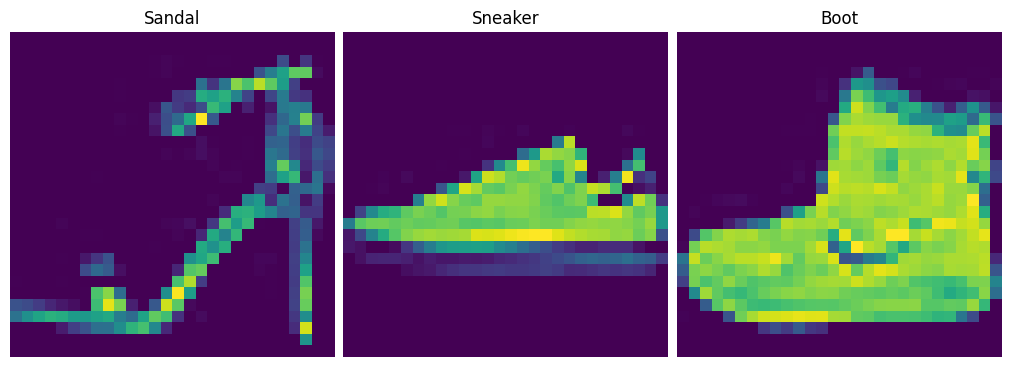

In [ ]:
names = ["Sandal", "Sneaker", "Boot"]

# Create a figure with subplots for each class
fig, ax = plt.subplots(1, 3, constrained_layout=True, figsize=(10, 4))

for i, ax in enumerate(ax):
    img = shoes[i].reshape(28, 28)

    ax.imshow(img)
    ax.set_title(names[i])
    ax.axis('off')

plt.show()
### print one image per ax. Example provided. Dont forget to reshape!

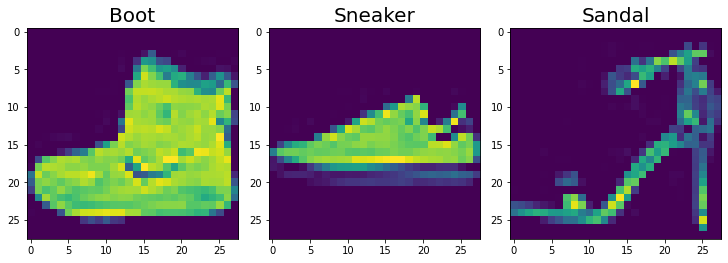

In [ ]:
### Example plot. Do not run.

# part 2.b

Your boss doesnt want to pay for the computing necessary for deep learning so were going to fit some classical models and hope for the best.

1. Split the data with a test_size = 0.33 and random_state 42 using the `train_test_split()` function.

2. Fit Naive Bayes, LDA, QDA, and Logistic Regression to the training data.

In [ ]:
x = shoes
y = labels

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

# fit models
logistic_regression = LogisticRegression()
lda = LDA()
qda = QDA()
naive_bayes = GaussianNB()

logistic_regression.fit(x_train, y_train)
lda.fit(x_train, y_train)
qda.fit(x_train, y_train)
naive_bayes.fit(x_train, y_train)

GaussianNB()

3. Print the training error and test error (Brier and Log).
4. Which model has the lowest train? Lowest test? Lowest difference between train and test?
Th model with the lowest train is the logistic regression model and the model with the lowest test is also the logistic regression model. The model with the lowest difference between train and test is lda for the brier score and logistic regression for the log score.

In [ ]:
# predict probabilities
logistic_regression_pred_test = logistic_regression.predict_proba(x_test)
lda_pred_test = lda.predict_proba(x_test)
qda_pred_test = qda.predict_proba(x_test)
naive_bayes_pred_test = naive_bayes.predict_proba(x_test)

logistic_regression_pred_train = logistic_regression.predict_proba(x_train)
lda_pred_train = lda.predict_proba(x_train)
qda_pred_train = qda.predict_proba(x_train)
naive_bayes_pred_train = naive_bayes.predict_proba(x_train)

In [ ]:
print('Brier score test')
print('')
print('Logistic Regression:', np.round(brier_score(y_test, logistic_regression_pred_test), 3))
print('LDA:', np.round(brier_score(y_test, lda_pred_test), 3))
print('QDA:', np.round(brier_score(y_test, qda_pred_test), 3))
print('Naive Bayes:', np.round(brier_score(y_test, naive_bayes_pred_test), 3))

print('')
print('Log score test')
print('')
print('Logistic Regression:', np.round(log_score(y_test, logistic_regression_pred_test), 3))
print('LDA:', np.round(log_score(y_test, lda_pred_test), 3))
print('QDA:', np.round(log_score(y_test, qda_pred_test), 3))
print('Naive Bayes:', np.round(log_score(y_test, naive_bayes_pred_test), 3))

print('')
print('Brier score train')
print('')
print('Logistic Regression:', np.round(brier_score(y_train, logistic_regression_pred_train), 3))
print('LDA:', np.round(brier_score(y_train, lda_pred_train), 3))
print('QDA:', np.round(brier_score(y_train, qda_pred_train), 3))
print('Naive Bayes:', np.round(brier_score(y_train, naive_bayes_pred_train), 3))

print('')
print('Log score train')
print('')
print('Logistic Regression:', np.round(log_score(y_train, logistic_regression_pred_train), 3))
print('LDA:', np.round(log_score(y_train, lda_pred_train), 3))
print('QDA:', np.round(log_score(y_train, qda_pred_train), 3))
print('Naive Bayes:', np.round(log_score(y_train, naive_bayes_pred_train), 3))


Brier score test

Logistic Regression: 0.096
LDA: 0.12
QDA: 0.718
Naive Bayes: 0.75

Log score test

Logistic Regression: 0.185
LDA: 0.452
QDA: 26.304
Naive Bayes: 27.239

Brier score train

Logistic Regression: 0.058
LDA: 0.092
QDA: 0.644
Naive Bayes: 0.721

Log score train

Logistic Regression: 0.109
LDA: 0.203
QDA: 23.539
Naive Bayes: 26.164


# part 2.c

1. Print the classification report for each method.
2. Which method is best in terms of F1 score?

The best method in terms of the highest F1 score was using the train data with logistic regression with an average F1 of .96 followed by using test data with logistic regression which yielded an F1 average score of .94

In [ ]:
# predict labels for each model
logistic_test = logistic_regression.predict(x_test)
lda_test = lda.predict(x_test)
qda_test = qda.predict(x_test)
naive_test = naive_bayes.predict(x_test)

logistic_train = logistic_regression.predict(x_train)
lda_train = lda.predict(x_train)
qda_train = qda.predict(x_train)
naive_train = naive_bayes.predict(x_train)

In [ ]:
# print classification report. Which is best in terms of F1?
logit_class_report = metrics.classification_report(y_test, logistic_test)
print("Logistic Report Test")
print(logit_class_report)

lda_class_report = metrics.classification_report(y_test, lda_test)
print("LDA Report Test")
print(lda_class_report)

qda_class_report = metrics.classification_report(y_test, qda_test)
print("QDA Report Test")
print(qda_class_report)

naive_class_report = metrics.classification_report(y_test, naive_test)
print("Naive Report Test")
print(naive_class_report)

logit_class_report2 = metrics.classification_report(y_train, logistic_train)
print("Logistic Report Train")
print(logit_class_report2)

lda_class_report2 = metrics.classification_report(y_train, lda_train)
print("LDA Report Train")
print(lda_class_report2)

qda_class_report2 = metrics.classification_report(y_train, qda_train)
print("QDA Report Train")
print(qda_class_report2)

naive_class_report2 = metrics.classification_report(y_train, naive_train)
print("Naive Report Train")
print(naive_class_report2)

Logistic Report Test
              precision    recall  f1-score   support

         5.0       0.95      0.94      0.94      1952
         7.0       0.92      0.93      0.92      2003
         9.0       0.94      0.94      0.94      1985

    accuracy                           0.94      5940
   macro avg       0.94      0.94      0.94      5940
weighted avg       0.94      0.94      0.94      5940

LDA Report Test
              precision    recall  f1-score   support

         5.0       0.95      0.92      0.93      1952
         7.0       0.89      0.93      0.91      2003
         9.0       0.94      0.93      0.94      1985

    accuracy                           0.93      5940
   macro avg       0.93      0.93      0.93      5940
weighted avg       0.93      0.93      0.93      5940

QDA Report Test
              precision    recall  f1-score   support

         5.0       0.91      0.25      0.39      1952
         7.0       0.52      0.97      0.68      2003
         9.0       0.8

# part 2.d

Compute and print the accuracy of each method. Which method has the highest accuracy?
The method with the highest accuracy was Logistic regression on the train data followed by logistic regression on the test data.

In [ ]:
logit_accuracy_test = metrics.classification_report(y_test, logistic_test, output_dict=True)['accuracy']
lda_accuracy_test = metrics.classification_report(y_test, lda_test, output_dict=True)['accuracy']
qda_accuracy_test = metrics.classification_report(y_test, qda_test, output_dict=True)['accuracy']
naive_accuracy_test = metrics.classification_report(y_test, naive_test, output_dict=True)['accuracy']

logit_accuracy_train = metrics.classification_report(y_train, logistic_train, output_dict=True)['accuracy']
lda_accuracy_train = metrics.classification_report(y_train, lda_train, output_dict=True)['accuracy']
qda_accuracy_train = metrics.classification_report(y_train, qda_train, output_dict=True)['accuracy']
naive_accuracy_train = metrics.classification_report(y_train, naive_train, output_dict=True)['accuracy']

print('Accuracy')
print('')
print("Logistic Accuracy Test")
print(logit_accuracy_test)
print('')
print("LDA Accuracy Test")
print(lda_accuracy_test)
print('')
print("QDA Accuracy Test")
print(qda_accuracy_test)
print('')
print("Naive Bayes Accuracy Test")
print(naive_accuracy_test)
print('')
print("Logistic Accuracy Train")
print(logit_accuracy_train)
print('')
print("LDA Accuracy Train")
print(lda_accuracy_train)
print('')
print("QDA Accuracy Train")
print(qda_accuracy_train)
print('')
print("Naive Bayes Accuracy Train")
print(naive_accuracy_train)

Accuracy

Logistic Accuracy Test
0.937037037037037

LDA Accuracy Test
0.9277777777777778

QDA Accuracy Test
0.641077441077441

Naive Bayes Accuracy Test
0.6244107744107744

Logistic Accuracy Train
0.963681592039801

LDA Accuracy Train
0.9422885572139303

QDA Accuracy Train
0.677860696517413

Naive Bayes Accuracy Train
0.6396351575456053


# part 2.e

The above results are dependent on the the specific seed we set in the train test split function.

How do we know the best model would still be the best if the data was split differently? Let's resplit the data a few times and determine which model is best on average.

1. Refit your models using 20 different seed values in the `train_test_split` function. Use seed values 0 to 19.
2. Recompute the test set brier score and accuracy for each seed.
3. Print out the average Brier score and accuracy and the standard deviation of each metric.
4. Is the best model always better than the others? Which model is best on average?

The best model on average is the logistic regression model and this model seems to pretty much always be better than the others based on the standard deviation.

In [ ]:
seeds = np.arange(20)

brier_scores = {'Logistic Regression': [], 'LDA': [], 'QDA': [], 'Naive Bayes': []}
accuracies = {'Logistic Regression': [], 'LDA': [], 'QDA': [], 'Naive Bayes': []}

for seed in seeds:
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=seed)

    # Fit models
    logistic_regression = LogisticRegression()
    lda = LDA()
    qda = QDA()
    naive_bayes = GaussianNB()

    logistic_regression.fit(x_train, y_train)
    lda.fit(x_train, y_train)
    qda.fit(x_train, y_train)
    naive_bayes.fit(x_train, y_train)

    logistic_regression_pred_test = logistic_regression.predict_proba(x_test)
    lda_pred_test = lda.predict_proba(x_test)
    qda_pred_test = qda.predict_proba(x_test)
    naive_bayes_pred_test = naive_bayes.predict_proba(x_test)

    logistic_test = logistic_regression.predict(x_test)
    lda_test = lda.predict(x_test)
    qda_test = qda.predict(x_test)
    naive_test = naive_bayes.predict(x_test)

    brier_scores['Logistic Regression'].append(brier_score(y_test, logistic_regression_pred_test))
    brier_scores['LDA'].append(brier_score(y_test, lda_pred_test))
    brier_scores['QDA'].append(brier_score(y_test, qda_pred_test))
    brier_scores['Naive Bayes'].append(brier_score(y_test, naive_bayes_pred_test))

    logit_accuracy_test = metrics.classification_report(y_test, logistic_test, output_dict=True)['accuracy']
    lda_accuracy_test = metrics.classification_report(y_test, lda_test, output_dict=True)['accuracy']
    qda_accuracy_test = metrics.classification_report(y_test, qda_test, output_dict=True)['accuracy']
    naive_accuracy_test = metrics.classification_report(y_test, naive_test, output_dict=True)['accuracy']

    accuracies['Logistic Regression'].append(logit_accuracy_test)
    accuracies['LDA'].append(lda_accuracy_test)
    accuracies['QDA'].append(qda_accuracy_test)
    accuracies['Naive Bayes'].append(naive_accuracy_test)

# Averages
for model in brier_scores:
    avg_brier = np.mean(brier_scores[model])
    std_brier = np.std(brier_scores[model])
    avg_accuracy = np.mean(accuracies[model])
    std_accuracy = np.std(accuracies[model])

    print(f"Model: {model}")
    print(f"Average Brier Score: {avg_brier:.3f}")
    print(f"Standard Deviation Brier Score: {std_brier:.3f}")
    print(f"Average Accuracy: {avg_accuracy:.3f}")
    print(f"Standard Deviation Accuracy: {std_accuracy:.3f}")
    print('')

Model: Logistic Regression
Average Brier Score: 0.093
Standard Deviation Brier Score: 0.004
Average Accuracy: 0.939
Standard Deviation Accuracy: 0.003

Model: LDA
Average Brier Score: 0.120
Standard Deviation Brier Score: 0.006
Average Accuracy: 0.928
Standard Deviation Accuracy: 0.004

Model: QDA
Average Brier Score: 0.753
Standard Deviation Brier Score: 0.015
Average Accuracy: 0.623
Standard Deviation Accuracy: 0.008

Model: Naive Bayes
Average Brier Score: 0.720
Standard Deviation Brier Score: 0.009
Average Accuracy: 0.640
Standard Deviation Accuracy: 0.005



# part 2.f

Based on everything you have seen in parts a-e. Which model would you choose and why? Explain using at least 3 sentences and using the metrics you saw above.

Based on everything we have found I would definetely choose the logistic regression model for the purposes of properly labeling the images of shoes. When we had the random state seed set at 42 The logistic regression model has the lowest brier score and log score for both the test and train data compared to the other models, and logistic regression had the highest F1 score with a .94 average for the test data. Logistic regression also has the highest accuracy with almost a .94 for the test data and over .96 with the train data. When we rain the model methods with different seeds values from 0 to 19, the logistic regression model again had a higher average brier score and accuracy than all of the other models confirming that it is indeed the best model to choose.